#Predicting Student Performance in edX using Browser Events
##By Joshua E. Jodesty

####Imports

In [88]:
import pandas as pd
from pandas.core.strings import StringMethods, compat
# compat.PY3 = True
import numpy as np
from datetime import datetime, timedelta
from pandas.tslib import Timedelta

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score

# Classification Metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, hamming_loss, zero_one_loss
from sklearn.metrics import brier_score_loss, jaccard_similarity_score,log_loss,matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support

# Plotting/Output
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import pydot
import pyparsing
import seaborn as sns
sns.set(color_codes=True)

### 1: Import Dataset

In [89]:
# * Convert dates into "datetime" value types
mooc = pd.read_csv('/home/jejodesty/metisProjects/kojak/HMXPC13_DI_v2_5-14-14.csv',
                    parse_dates=['start_time_DI', 'last_event_DI'], # *
                    infer_datetime_format=True) # *
cols = [col for col in mooc.columns]
rows = len(mooc)

### 2. Check column names, value types, and unique values

In [3]:
print 'Columns:', cols 
print 'ROWS:',rows

Columns: ['course_id', 'userid_DI', 'registered', 'viewed', 'explored', 'certified', 'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade', 'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts', 'roles', 'incomplete_flag']
ROWS: 641138


In [4]:
def explore(df):
    column_list = df.columns.values.tolist()
    print 'Rows:', len(mooc)
    print
    for column_name in column_list:
        print column_name, type(df[column_name].iloc[0])
        print df[column_name].unique()
        print

In [5]:
explore(mooc)

Rows: 641138

course_id <type 'str'>
['HarvardX/CB22x/2013_Spring' 'HarvardX/CS50x/2012'
 'HarvardX/ER22x/2013_Spring' 'HarvardX/PH207x/2012_Fall'
 'HarvardX/PH278x/2013_Spring' 'MITx/6.002x/2012_Fall'
 'MITx/6.002x/2013_Spring' 'MITx/14.73x/2013_Spring'
 'MITx/2.01x/2013_Spring' 'MITx/3.091x/2012_Fall' 'MITx/3.091x/2013_Spring'
 'MITx/6.00x/2012_Fall' 'MITx/6.00x/2013_Spring' 'MITx/7.00x/2013_Spring'
 'MITx/8.02x/2013_Spring' 'MITx/8.MReV/2013_Summer']

userid_DI <type 'str'>
['MHxPC130442623' 'MHxPC130275857' 'MHxPC130539455' ..., 'MHxPC130184108'
 'MHxPC130359782' 'MHxPC130098513']

registered <type 'numpy.int64'>
[1]

viewed <type 'numpy.int64'>
[0 1]

explored <type 'numpy.int64'>
[0 1]

certified <type 'numpy.int64'>
[0 1]

final_cc_cname_DI <type 'str'>
['United States' 'France' 'Unknown/Other' 'Mexico' 'Australia' 'India'
 'Canada' 'Russian Federation' 'Other South Asia'
 'Other North & Central Amer., Caribbean' 'Other Europe' 'Other Oceania'
 'Japan' 'Other Africa' 'Colombia' 

### 3. Cleanse & Transform Dataset

In [6]:
%time 
# Remove inconsistent records
mooc = mooc[mooc.incomplete_flag != 1]

mooc['grade'] = mooc.grade.fillna(' ')
mooc = mooc[mooc.grade != ' ']
mooc['grade'] = mooc['grade'].astype(float) 

mooc['LoE_DI'] = mooc.LoE_DI.fillna(0)
mooc = mooc[mooc.LoE_DI != 0]
mooc['LoE_DI'] = mooc['LoE_DI'].map({'Less than Secondary':0,'Secondary':1,
                                     "Bachelor's":2,"Master's":3,'Doctorate':4})

mooc['YoB'] = mooc.YoB.fillna(0)
mooc = mooc[mooc.YoB != 0]

mooc['start_time_DI'] = mooc.start_time_DI.fillna(0)
mooc = mooc[mooc.start_time_DI != 0]
mooc['start_time_DI'] = pd.DatetimeIndex(mooc['start_time_DI']).date

mooc['last_event_DI'] = mooc.last_event_DI.fillna(0)
mooc = mooc[mooc.last_event_DI != 0]
mooc['last_event_DI'] = pd.DatetimeIndex(mooc['last_event_DI']).date

mooc['nevents'] = mooc.nevents.fillna(0)
mooc = mooc[mooc.nevents != 0]

mooc['ndays_act'] = mooc.ndays_act.fillna(0)
mooc = mooc[mooc.ndays_act != 0]

mooc['nplay_video'] = mooc.nplay_video.fillna(0)
mooc = mooc[mooc.nplay_video != 0]

mooc['nchapters'] = mooc.nchapters.fillna(0)
mooc = mooc[mooc.nchapters != 0]

mooc['gender'] = mooc.gender.fillna(0)
mooc = mooc[mooc.gender != 0]

CPU times: user 13 µs, sys: 1 µs, total: 14 µs
Wall time: 31 µs


### 2. Define functions that return new values when applied to a row

In [7]:
# Return letter grade (grade ranges) for each row
def letter_grade(row):
    grd = row.grade
    letter = ''
    if (0.90 <= grd <= 1): letter = 'A'
    elif (0.80 <= grd < 0.90): letter = 'B'
    elif (0.70 <= grd < 0.80): letter = 'C'
    elif (0.60 <= grd < 0.70): letter = 'D'
    else: letter = 'F'
    return letter

# Return age range for each row
def age_range(row):
    rng = ''
    if (13 <= row.age < 18): rng = 'teenagers < 18'
    elif (18 <= row.age < 30): rng = '18-29'
    elif (30 <= row.age < 40): rng = '30s'
    elif (40 <= row.age < 50): rng = '40s'
    elif (50 <= row.age < 60): rng = '50s'
    elif (60 <= row.age < 70): rng = '60s'
    elif (70 <= row.age): rng = '70+'
    else: rng = ' '
    return rng

# Return value of row with a specific course value
def get_course_value(row, df):
    for crs_code in df.index:
        if row.course_code == crs_code:
            return int(df.loc[crs_code].item())
        
# Convert Registration Duration into days
# def registration_duration_2_days(row):
#     return int(str(Timedelta(value=row.registration_duration,unit='D')).split()[0])

### 3. Generate New Features

In [8]:
# New Features
%time
mooc['letter_grade'] = mooc.apply(lambda row: letter_grade(row),axis=1)
mooc['outcome'] = (mooc['certified'].replace(1, 'Certified:').replace(0, 'Not Certified:') 
                   + ' ' + mooc['letter_grade']).map({'Not Certified: F':0,'Not Certified: D':1,
                                                      'Not Certified: C':2,'Certified: F':3,'Certified: D':4,
                                                      'Certified: C':5,'Certified: B':6,'Certified: A':7})
mooc['Outcome'] = mooc['outcome'].map({0:'Not Certified: F',1:'Not Certified: D',
                                      2:'Not Certified: C',3:'Certified: F',4:'Certified: D',
                                      5:'Certified: C',6:'Certified: B',7:'Certified: A'})

mooc['institution'] = mooc['course_id'].str.split("/",return_type='frame',)[0]
mooc['course_code'] = mooc['course_id'].str.split("/",return_type='frame',)[1]
mooc['semester'] = mooc['course_id'].str.split("/",return_type='frame',)[2]

mooc['start_year'] = mooc['semester'].str.split("_",return_type='frame',)[0].astype('int') #pd.DatetimeIndex(pd.to_datetime(mooc['start_time_DI'])).year
mooc['age'] = mooc['start_year'] - mooc['YoB']

mooc['age_range'] = mooc.apply(lambda row: age_range(row),axis=1)
mooc = mooc[mooc.age_range != ' ']

# Completion/Comparison
max_chaps_completed = mooc[['course_code', 'nchapters']].groupby(['course_code']).max()
mooc['max_nchapters'] = mooc.apply(lambda row: get_course_value(row, max_chaps_completed),axis=1)
mooc['%max_chapters_viewed'] = mooc['nchapters'].divide(mooc['max_nchapters']) #(td / np.timedelta64(1, 'D')).astype(int)

# Completion/Comparison
max_video_views = mooc[['course_code', 'nplay_video']].groupby(['course_code']).max()
mooc['max_nplay_video'] = mooc.apply(lambda row: get_course_value(row, max_video_views),axis=1)
# mooc['%max_videos_viewed'] = mooc['nplay_video'].divide(mooc['max_nplay_video'])

# Comparison
max_posts = mooc[['course_code', 'nforum_posts']].groupby(['course_code']).max()
mooc['max_nforum_posts'] = mooc.apply(lambda row: get_course_value(row, max_posts),axis=1)
# mooc['%max_posts_viewed'] = mooc['nforum_posts'].divide(mooc['max_nforum_posts'])

# Comparison
max_events = mooc[['course_code', 'nevents']].groupby(['course_code']).max()
mooc['max_nevents'] = mooc.apply(lambda row: get_course_value(row, max_events),axis=1)
# mooc['%max_events'] = mooc['nevents'].divide(mooc['max_nevents'])

# Comparison
max_days_act = mooc[['course_code', 'ndays_act']].groupby(['course_code']).max()
mooc['max_ndays_act'] = mooc.apply(lambda row: get_course_value(row, max_days_act),axis=1)
# mooc['%max_days_act'] = mooc['ndays_act'].divide(mooc['max_ndays_act'])

# Interaction Ratios: <= 1% Interactions/events
# (u'ndays_act', u'nplay_video', u'nchapters', u'nforum_posts') / u'nevents' 
mooc['nplay_video/nevents'] = (mooc['nplay_video'].divide(mooc['nevents'])).fillna(0)
mooc['nchapters/nevents'] = (mooc['nchapters'].divide(mooc['nevents'])).fillna(0)
mooc['nforum_posts/nevents'] = (mooc['nforum_posts'].divide(mooc['nevents'])).fillna(0)

# Events Per Day: <= 1 day
# (u'nplay_video', u'nchapters', u'nevents', u'nforum_posts') Per Day
mooc['nevents_per_day'] = (mooc['nevents'].divide(mooc['max_ndays_act'])).fillna(0)
mooc['nplay_video_per_day'] = (mooc['nplay_video'].divide(mooc['max_ndays_act'])).fillna(0)
mooc['nchapters_per_day'] = (mooc['nchapters'].divide(mooc['max_ndays_act'])).fillna(0)
mooc['nforum_posts_per_day'] = (mooc['nforum_posts'].divide(mooc['max_ndays_act'])).fillna(0)

# Days spent on specific events
mooc['ndays_play_video'] = (mooc['nplay_video'] * mooc['ndays_act'].divide(mooc['nplay_video'])).fillna(0)
mooc['ndays_chapters'] = (mooc['nchapters'] * mooc['ndays_act'].divide(mooc['nchapters'])).fillna(0)
mooc['ndays_forum_posts'] = (mooc['nforum_posts'] * mooc['ndays_act'].divide(mooc['nforum_posts'])).fillna(0)

# This feature was intended to determin the number of days a student was inactive
# mooc['registration_duration'] = (mooc['last_event_DI'] - mooc['start_time_DI'])
# mooc = mooc[mooc['registration_duration'].astype(int) >= 0]
# mooc['registration_duration'] = mooc.apply(lambda row: register_duration_2_days(row),axis=1)

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 31 µs


/home/jejodesty/anaconda/lib/python2.7/site-packages/pandas/util/decorators.py:81: FutureWarning: the return_type='frame' keyword is deprecated, use expand=True instead
  warnings.warn(msg, FutureWarning)


In [47]:
mooc.columns

Index([u'course_id', u'userid_DI', u'registered', u'viewed', u'explored',
       u'certified', u'final_cc_cname_DI', u'LoE_DI', u'YoB', u'gender',
       u'grade', u'start_time_DI', u'last_event_DI', u'nevents', u'ndays_act',
       u'nplay_video', u'nchapters', u'nforum_posts', u'roles',
       u'incomplete_flag', u'letter_grade', u'outcome', u'Outcome',
       u'institution', u'course_code', u'semester', u'start_year', u'age',
       u'age_range', u'max_nchapters', u'%max_chapters_viewed',
       u'max_nplay_video', u'max_nforum_posts', u'max_nevents',
       u'max_ndays_act', u'nplay_video/nevents', u'nchapters/nevents',
       u'nforum_posts/nevents', u'nevents_per_day', u'nplay_video_per_day',
       u'nchapters_per_day', u'nforum_posts_per_day', u'ndays_play_video',
       u'ndays_chapters', u'ndays_forum_posts'],
      dtype='object')

###4. Check enrollment & Grade Range counts

In [9]:
course_enrollment = pd.DataFrame(mooc['course_code'].value_counts())
institution_enrollment = pd.DataFrame(mooc['institution'].value_counts())
letter_grade = pd.DataFrame(mooc['letter_grade'].value_counts())

print 'HarvardX courses:', mooc['course_code'][mooc['institution'] == 'HarvardX'].unique()
print 'MITx courses:', mooc['course_code'][mooc['institution'] == 'MITx'].unique()
print
print 'Student Enrollement per School'
print institution_enrollment
print
print 'Student Enrollement per Course'
print course_enrollment
print
print 'Letter Grades (Grade Ranges)'
print letter_grade

HarvardX courses: ['PH207x' 'PH278x']
MITx courses: ['14.73x' '8.02x' '6.00x' '6.002x' '7.00x' '8.MReV' '2.01x' '3.091x']

Student Enrollement per School
               0
MITx      104644
HarvardX   25199

Student Enrollement per Course
            0
6.00x   51437
PH207x  16516
6.002x  15919
14.73x  10655
8.02x   10544
PH278x   8683
7.00x    7614
3.091x   6022
2.01x    2099
8.MReV    354

Letter Grades (Grade Ranges)
        0
F  120060
A    3633
B    2827
C    1755
D    1568


###5. Data Exploration: All Courses

#### Pairplot & Interpret in order to recieve genralized insight into the dataset

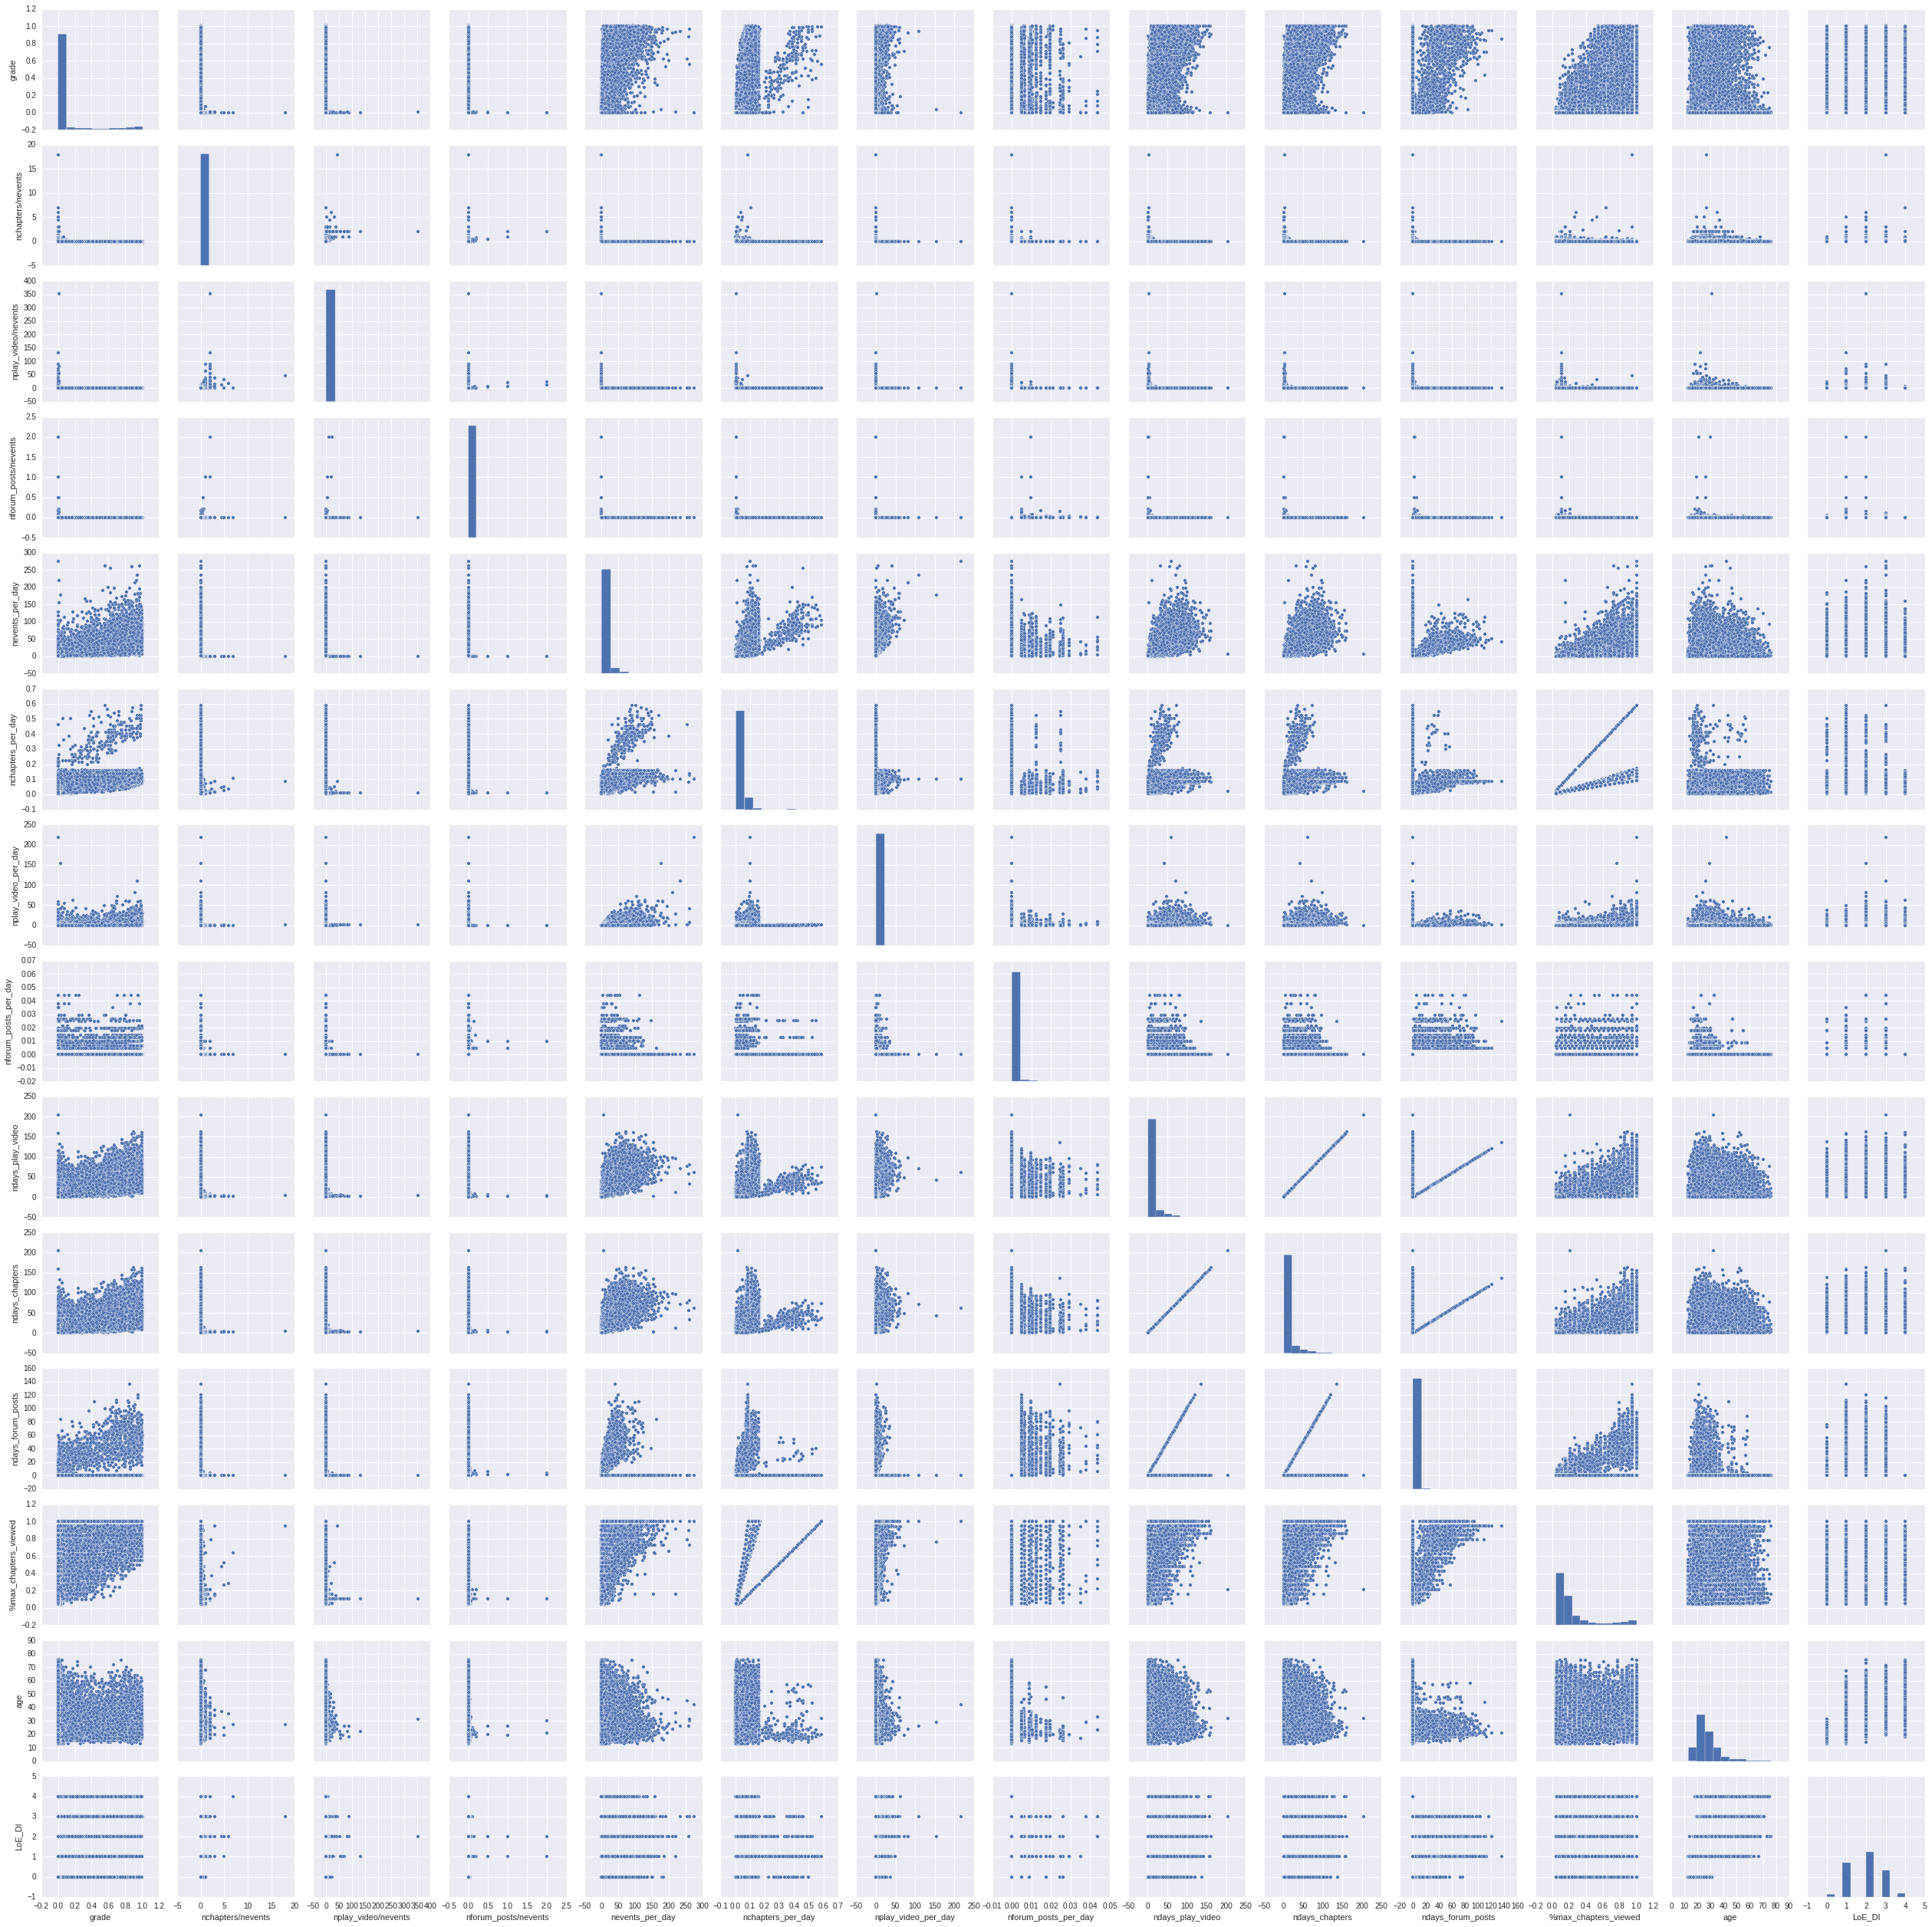

In [72]:
#paiplot
plot_cols = ['grade','nchapters/nevents','nplay_video/nevents','nforum_posts/nevents',
                'nevents_per_day','nchapters_per_day','nplay_video_per_day','nforum_posts_per_day',
                'ndays_play_video','ndays_chapters','ndays_forum_posts',
                '%max_chapters_viewed',
                'age','age_range','LoE_DI','final_cc_cname_DI','gender','institution','course_code','semester']
mooc_plot = mooc[plot_cols]
sns.pairplot(mooc_plot)

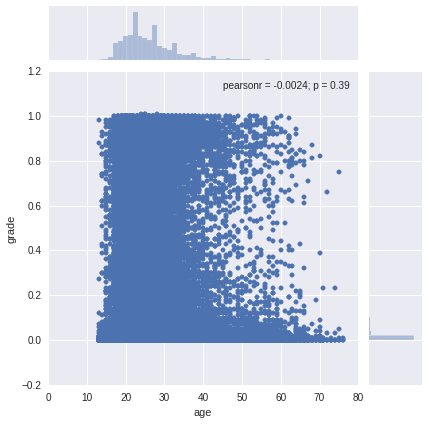

In [16]:
sns.jointplot(x="age", y="grade", data=mooc) #Heatmap

Interpretations & Conditions:
* Theres a bimodal distribution of grade ranges begining when students are in their mid 30s
* Most students are in their 20s according to the y-axis histogram
* Most students fail there courses according to the x-axis histogram
* There are some students who are preteens. They seem to be outliers.

Conclusion: Age is not correlated to grade according to the **Pearson correlation coefficient** (**pearsonr**) equalling approximately 0.00 and the high **p-value** (**p**)

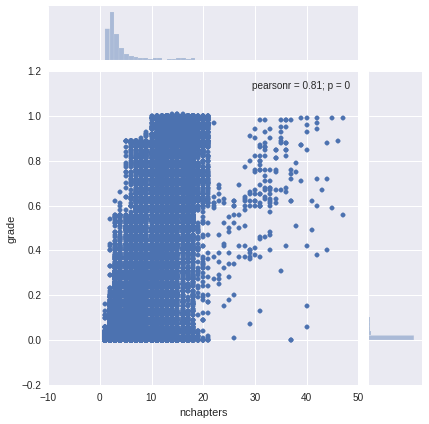

In [17]:
sns.jointplot(x='nchapters',y='grade',data=mooc)

Interpretations:
* It seems as though most courses had a maximum limit of 21 chapters, and some of those limits where lifted to inculde more chapters at some point in time
* Most students read less than 5 chapters based on y-axis histogram
* Most students fail there courses based on x-axis histogram

Conditions: 
* ([0.2  <= grade <=1] | [nchapters > 0])
* ([0 <= grade <= 0.9] | [4 <= nchapters <= 8])
* ([grade => 0.9] | [8 <= nchapters <= 21])

Transformation: Transformed this feature into Percentage of Maximum Chapters Viewed

Conclusion: The number of chapters viewed is correlated to grade according to the **Pearson correlation coefficient** (**pearsonr**) equalling 0.81 and the **p-value** (**p**) equalling 0.

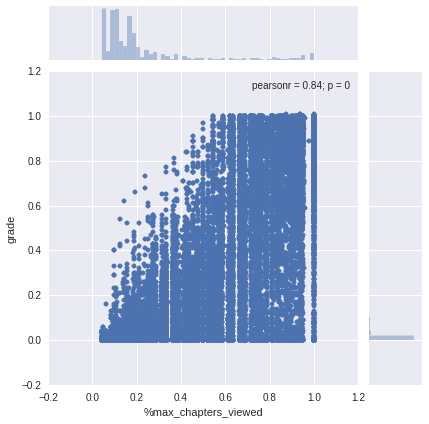

In [18]:
sns.jointplot(x='%max_chapters_viewed',y='grade',data=mooc)

Interpretations:
* Students the possibility of recieving higher grades increases as the amount of chapters viewed inreases
* No students had the possibilty of recieving grade 100 if they viewd less than 47% of the chapters
* Most students view less than 20% of chapters
* Most students fail there courses based on x-axis histogram

Conclusion: The Percentage of Maximum Chapters Viewed is correlated to grade according to the **Pearson correlation coefficient** (**pearsonr**) equalling 0.84 and the **p-value** (**p**) equalling 0.

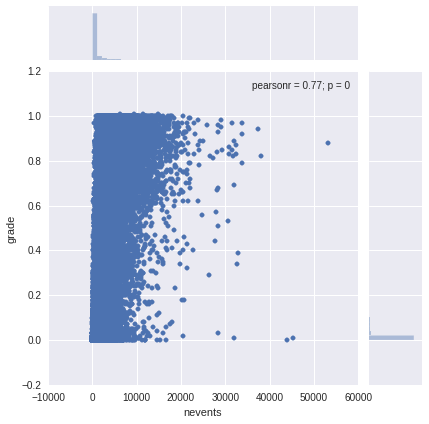

In [19]:
sns.jointplot(x='nevents',y='grade',data=mooc)

Interpretations & Conditions:
* Most students execute around 1000 events
* For most students' who didn't fail, their grades increase after around 7000 events
* Outliers: There are 4 students who received 0% grades with the most events. These students seem to be registering for courses solely to have access to the courseware.
* Most students fail there courses based on x-axis histogram

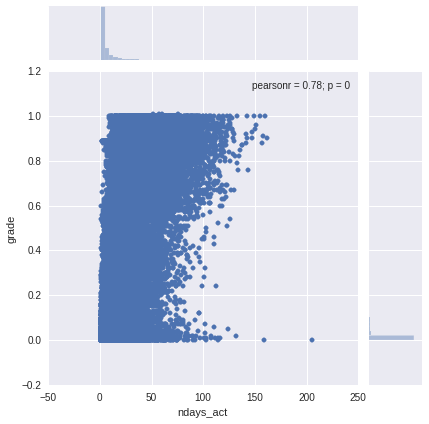

In [20]:
sns.jointplot(x='ndays_act',y='grade',data=mooc)

Interpretations & Conditions:
* Most students are active less than 40 days 
* For most students' who didn't fail, their grades increase after around 60 days
* Outliers: There are 2 students who are active for the most amount of days. These students seem to be registering for courses solely to have access to the courseware.
* Most students fail there courses based on x-axis histogram

Conclusion: The Percentage of Maximum Chapters Viewed is correlated to grade according to the **Pearson correlation coefficient** (**pearsonr**) equalling 0.78 and the **p-value** (**p**) equalling 0.

###6. Create datasets for predicting outcomes and grade ranges in schools and courses

In [86]:
cols_grade = ['grade', 
    'viewed','explored','ndays_act','nplay_video','%max_chapters_viewed','nevents','nforum_posts',
    'LoE_DI','age','age_range','final_cc_cname_DI','gender',
    'institution','course_code', 'semester','start_year']
cols_letter_grade = ['letter_grade',
    'viewed','explored','ndays_act','nplay_video','%max_chapters_viewed','nevents','nforum_posts',
    'LoE_DI','age','age_range','final_cc_cname_DI','gender',
    'institution','course_code', 'semester','start_year']
cols_cert = ['certified', 
    'viewed','explored','ndays_act','nplay_video','%max_chapters_viewed','nevents','nforum_posts',
    'LoE_DI','age','age_range','final_cc_cname_DI','gender',
    'institution','course_code', 'semester','start_year']

# mooc_grade = mooc[cols_grade]
mooc_letter = mooc[cols_letter_grade]
mooc_cert = mooc[cols_cert]

# Add Shuffling
y_let = mooc_letter['letter_grade'].map({'F':0, 'A':1, 'B':2, 'C':3, 'D':4})
X_let = pd.get_dummies(mooc_letter[cols_letter_grade[1:]])

y_HarvardX_letter = mooc_letter['letter_grade'][mooc_letter['institution']=='HarvardX'].map({'F':0, 'A':1, 'B':2, 'C':3, 'D':4})
X_HarvardX_letter = pd.get_dummies(mooc_letter[cols_letter_grade[1:]][mooc['institution']=='HarvardX'])

y_MITx_letter = mooc_letter['letter_grade'][mooc_letter['institution']=='MITx'].map({'F':0, 'A':1, 'B':2, 'C':3, 'D':4})
X_MITx_letter = pd.get_dummies(mooc_letter[cols_letter_grade[1:]][mooc_letter['institution']=='MITx'])

y_HarvardX_cert = mooc_cert['certified'][mooc_cert['institution']=='HarvardX']
X_HarvardX_cert = pd.get_dummies(mooc_cert[cols_cert[1:]][mooc_cert['institution']=='HarvardX'])

y_MITx_cert = mooc_cert['certified'][mooc_cert['institution']=='MITx']
X_MITx_cert = pd.get_dummies(mooc_cert[cols_cert[1:]][mooc_cert['institution']=='MITx'])

X_train_let, X_test_let, y_train_let, y_test_let = train_test_split(X_let, y_let, test_size=0.25, random_state=777)

X_train_H_let, X_test_H_let, y_train_H_let, y_test_H_let = train_test_split(
    X_HarvardX_letter, y_HarvardX_letter, test_size=0.25, random_state=777)

X_train_M_let, X_test_M_let, y_train_M_let, y_test_M_let = train_test_split(
    X_MITx_letter, y_MITx_letter, test_size=0.25, random_state=777)

X_train_H_cert, X_test_H_cert, y_train_H_cert, y_test_H_cert = train_test_split(
    X_HarvardX_cert, y_HarvardX_cert, test_size=0.25, random_state=777)

X_train_M_cert, X_test_M_cert, y_train_M_cert, y_test_M_cert = train_test_split(
    X_MITx_cert, y_MITx_cert, test_size=0.25, random_state=777)

###7. Model, Evaluate, & Compare Classification Estimators/Algorithms: Y = certified

In [76]:
names, accs = [],[]
def binaryClass_eval(X_train, y_train, X_test, y_test):
    global names, accs
    names, accs = [],[]
    y_true = np.array(y_test)
    for algorithm in (LogisticRegression, #
                     KNeighborsClassifier,
                     GaussianNB,
                     DecisionTreeClassifier,
                     RandomForestClassifier):

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        accuracy = np.mean(cross_val_score(
                algorithm().fit(X_train, y_train), X_test, y_test, cv=10, scoring='accuracy'))
        precision = np.mean(cross_val_score(
                algorithm().fit(X_train, y_train), X_test, y_test, cv=10, scoring='precision'))
        recall = np.mean(cross_val_score(algorithm(), X_test, y_test, cv=10, scoring='recall'))
        f1 = np.mean(cross_val_score(algorithm(), X_test, y_test, cv=10, scoring='f1_weighted'))
    
        if algorithm is SVC:
            model = []
            model = SVC(probability=True).fit(X_train, y_train)
            y_score = model.predict_proba(X_test)
            fpr, tpr, thresholds = roc_curve(y_true, y_score[:,1])
            roc_auc = auc(fpr, tpr)
        elif algorithm is DecisionTreeClassifier:
            model = []
            model = DecisionTreeClassifier().fit(X_train, y_train)
            y_score = model.predict_proba(X_test)
            fpr, tpr, thresholds = roc_curve(y_true, y_score[:,1])
            roc_auc = auc(fpr, tpr)
        else:
            model = []
            model = algorithm().fit(X_train, y_train)
            y_score = model.predict_proba(X_test)
            fpr, tpr, thresholds = roc_curve(y_true, y_score[:,1])
            roc_auc = auc(fpr, tpr)

        names.append(algorithm.__name__)
        accs.append(accuracy)
        print '%-30s' % (algorithm.__name__)
        print '%s %.4f' % ("Accuracy:", accuracy)
        print '%s %.4f' % ("Precision:", precision)
        print '%s %.4f' % ("Recall:", recall)
        print '%s %.4f' % ("f1:", f1)
        print '%s %.4f' % ("AUC:", roc_auc)
        print ''

        # Plot of a ROC curve for a specific class
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

LogisticRegression            
Accuracy: 0.9476
Precision: 0.7307
Recall: 0.6974
f1: 0.9471
AUC: 0.9789



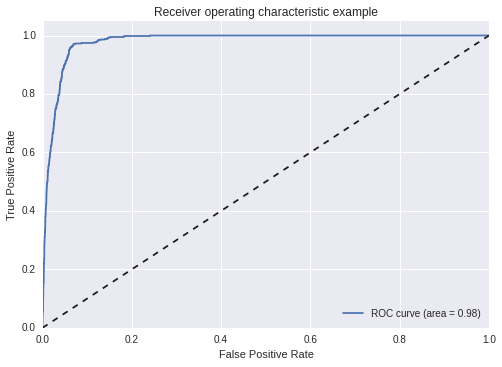

KNeighborsClassifier          
Accuracy: 0.9252
Precision: 0.6091
Recall: 0.5578
f1: 0.9236
AUC: 0.9315



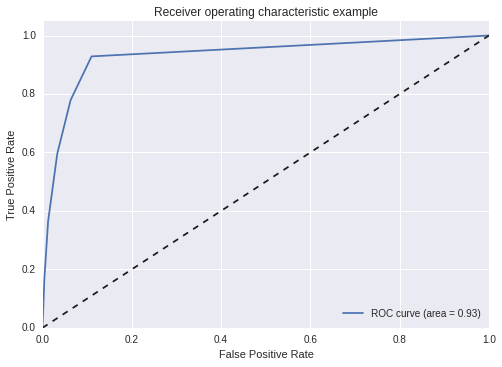

GaussianNB                    
Accuracy: 0.8109
Precision: 0.3593
Recall: 0.9354
f1: 0.8432
AUC: 0.9165



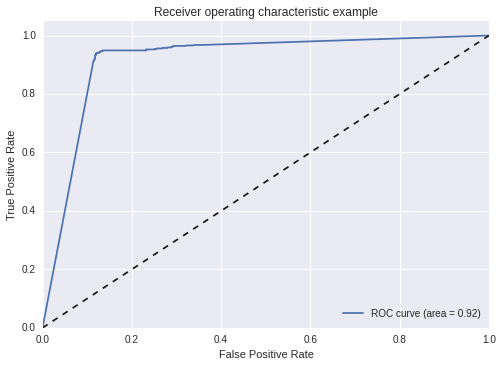

DecisionTreeClassifier        
Accuracy: 0.9435
Precision: 0.6852
Recall: 0.7008
f1: 0.9431
AUC: 0.8508



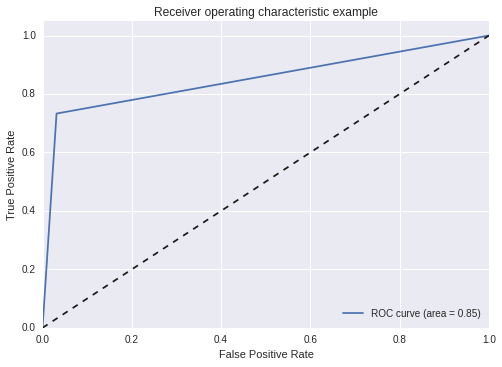

RandomForestClassifier        
Accuracy: 0.9473
Precision: 0.7513
Recall: 0.6973
f1: 0.9453
AUC: 0.9702



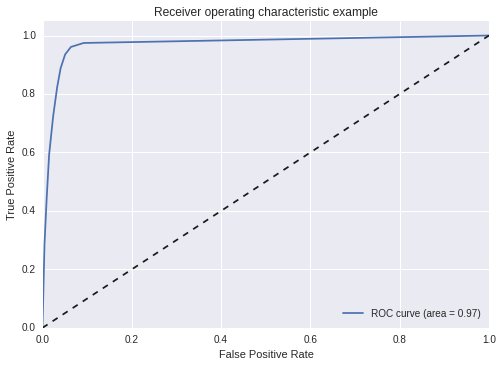

In [77]:
binaryClass_eval(X_train_H_cert, y_train_H_cert, X_test_H_cert, y_test_H_cert)
# binaryClass_eval(X_train_M_cert, y_train_M_cert, X_test_M_cert, y_test_M_cert)

###8. Model, Evaluate, & Compare performance metrics of various Classification Estimators/Algorithms: Y = letter grade

In [78]:
conf_matrixs, class_reports, acc_score_fracts = [],[],[]
acc_score_nums, zero_one_loss_fracts, zero_one_loss_nums = [],[],[]
y_preds, models = [],[]

def multiClass_eval(X_train, y_train, X_test, y_test):
    global conf_matrixs, class_reports, acc_score_fracts, acc_score_nums, zero_one_loss_fracts, zero_one_loss_nums 
    global y_preds, models
    
    conf_matrixs, class_reports, acc_score_fracts = [],[],[]
    acc_score_nums, zero_one_loss_fracts, zero_one_loss_nums = [],[],[]
    y_preds, models = [],[]
    for estimator in (LogisticRegression, 
                     KNeighborsClassifier,
                     GaussianNB,
                     DecisionTreeClassifier,
                     RandomForestClassifier):

        model = estimator().fit(X_train, y_train)
        models.append(model)

        y_pred = model.predict(X_test)
        y_preds.append(y_pred)

        cm = confusion_matrix(y_test, y_pred)
        conf_matrixs.append(cm)

        cr = classification_report(y_test, y_pred, target_names=['F', 'A', 'B', 'C', 'D'])
        
        class_reports.append(cr)

        asf = accuracy_score(y_test, y_pred)
        acc_score_fracts.append(asf)

        asn = accuracy_score(y_test, y_pred, normalize=False)
        acc_score_nums.append(asn)

        zolf = zero_one_loss(y_test, y_pred) 
        zero_one_loss_fracts.append(zolf)

        zoln = zero_one_loss(y_test, y_pred, normalize=False)
        zero_one_loss_nums.append(zoln)

        print '%s %-30s' % ('Estimator:', estimator.__name__)
        print
        print 'Confusion Matrix:'
        print cm
        print
        print 'Classification_Report:'
        print cr
        print
        print '%s %.4f %s' % ("Accuracy Score:", asf, '- fraction of correctly classified samples')
        print '%s %d %s' % ("               ", asn, ' - number of correctly classified samples')
        print '%s %.4f %s' % (" Zero One Loss:", zolf, '- return the fraction of misclassifications')
        print '%s %d %s' % ("               ", zoln, '  - number of misclassifications')
        print 

In [79]:
%time
multiClass_eval(X_train_let, y_train_let, X_test_let, y_test_let)

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 34.1 µs
Estimator: LogisticRegression            

Confusion Matrix:
[[29812   117    55     4    15]
 [  249   513   164     3     3]
 [  264   206   215     6    19]
 [  186   103   137     2    13]
 [  222    65    64     6    18]]

Classification_Report:
             precision    recall  f1-score   support

          F       0.97      0.99      0.98     30003
          A       0.51      0.55      0.53       932
          B       0.34      0.30      0.32       710
          C       0.10      0.00      0.01       441
          D       0.26      0.05      0.08       375

avg / total       0.92      0.94      0.93     32461


Accuracy Score: 0.9414 - fraction of correctly classified samples
                30560  - number of correctly classified samples
 Zero One Loss: 0.0586 - return the fraction of misclassifications
                1901   - number of misclassifications

Estimator: KNeighborsClassifier          

Confusion Mat

###9. Get Feature Importances of best model to compare to other models: Y = letter

In [81]:
def get_importances(model, Y=None):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_rank = []
    i = len(model)
    print "Number of most important features: ", len(model)
    print("Feature ranking:") # create table
    f_range = []
    for f in range(len(model)):
        f_range.append(f + 1)
        top_rank.append(indices[f])
        
        if Y == 'Outcome': print("%d. %s" % (f + 1, X[top_rank].columns[f]))
        elif Y == 'letter':
            print("%d. # %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], 
                                        X_let[top_rank].columns[f]))
        elif Y == None:
            print "Enter Target: 'Outcome' or 'letter'"
            
    ax = sns.barplot(range(len(indices[0:10])),importances[indices[0:10]], palette="Set3")
    ax.set(ylabel="Importance")
    ax.set(xlabel="Rank")

Number of most important features:  10
Feature ranking:
1. # 2 (0.215010) ndays_act
2. # 5 (0.200615) nevents
3. # 4 (0.158416) %max_chapters_viewed
4. # 3 (0.117531) nplay_video
5. # 8 (0.058856) age
6. # 1 (0.030088) explored
7. # 7 (0.026069) LoE_DI
8. # 6 (0.009506) nforum_posts
9. # 27 (0.009411) final_cc_cname_DI_India
10. # 49 (0.009337) final_cc_cname_DI_United States


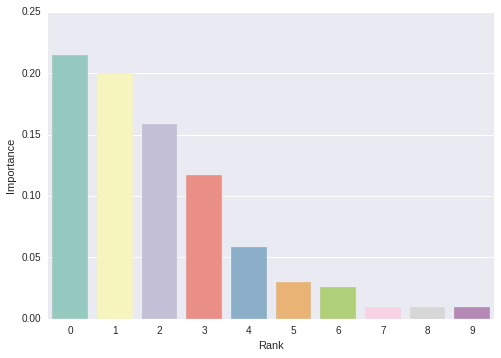

In [82]:
get_importances(models[4], Y='letter')

###10. Model, Evaluate, & Compare performance metrics of various Classification Estimators/Algorithms: Y = letter grade (mapped to continuous)

In [92]:
def eval_estimator(estimator, X_train, y_train, X_test, y_test, target, Y=None):
    model = estimator().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    asf = accuracy_score(y_test, y_pred)
    asn = accuracy_score(y_test, y_pred, normalize=False)

    zolf = zero_one_loss(y_test, y_pred) 
    zoln = zero_one_loss(y_test, y_pred, normalize=False)

    print 'Target:', target
    print '%s %-30s' % ('Estimator:', estimator.__name__)
    print
    print 'Confusion Matrix:'
    print cm
    print
    print 'Classification_Report:'
    print cr
    print
    print '%s %.4f %s' % ("Accuracy Score:", asf, '- fraction of correctly classified samples')
    print '%s %d %s' % ("               ", asn, ' - number of correctly classified samples')
    print '%s %.4f %s' % (" Zero One Loss:", zolf, '- return the fraction of misclassifications')
    print '%s %d %s' % ("               ", zoln, '  - number of misclassifications')
    print

    get_importances(model, Y)

Target: HarvardX
Estimator: RandomForestClassifier        

Confusion Matrix:
[[5589   56   15    7    3]
 [  79  226   28    1    0]
 [  59   74   26   11    0]
 [  28   20   19    6    3]
 [  28   11    5    3    3]]

Classification_Report:
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      5670
          1       0.58      0.68      0.63       334
          2       0.28      0.15      0.20       170
          3       0.21      0.08      0.12        76
          4       0.33      0.06      0.10        50

avg / total       0.91      0.93      0.92      6300


Accuracy Score: 0.9286 - fraction of correctly classified samples
                5850  - number of correctly classified samples
 Zero One Loss: 0.0714 - return the fraction of misclassifications
                450   - number of misclassifications

Number of most important features:  10
Feature ranking:
1. # 2 (0.186214) ndays_act
2. # 5 (0.163425) nevents
3. # 1 (0.137483) expl

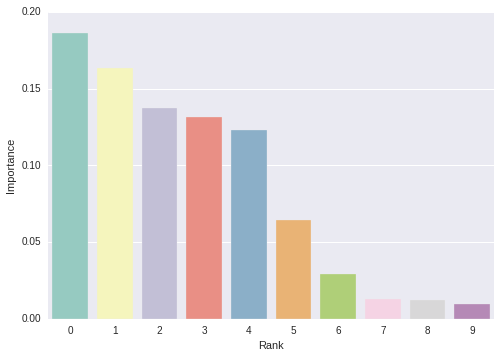

In [87]:
eval_estimator(RandomForestClassifier, X_train_H_let, y_train_H_let, X_test_H_let, y_test_H_let, 'HarvardX', Y='letter')

### 11. Data Exploration: One Courses

####Create a dataframe of students in course 6.00x


In [21]:
outcome_cols = ['Outcome','outcome','certified','letter_grade','grade',
                'nevents','nchapters','nplay_video','nforum_posts','age',
                'ndays_act','ndays_chapters','ndays_play_video','ndays_forum_posts',
                'nchapters/nevents', 
                'nplay_video/nevents',
                'nforum_posts/nevents',
                'nevents_per_day',
                'nchapters_per_day',
                'nplay_video_per_day',
                'nforum_posts_per_day',
                '%max_chapters_viewed',
                'age_range','LoE_DI','final_cc_cname_DI','gender',
                'institution','course_code','semester']

MITx_600x = (mooc[outcome_cols][(mooc['course_code']=='6.00x')]).dropna(subset=outcome_cols)
# MITx_600x['Outcome'] = MITx_600x['outcome'].map({0:'Not Certified: F',1:'Not Certified: D',
#                                                       2:'Not Certified: C',3:'Certified: F',4:'Certified: D',
#                                                       5:'Certified: C',6:'Certified: B',7:'Certified: A'})

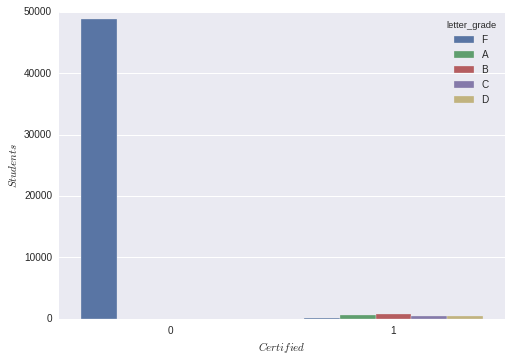

In [22]:
ax = sns.countplot(x="certified", hue="letter_grade", data=MITx_600x)
ax.set(ylabel='$Students$')
ax.set(xlabel='$Certified$')

Interpretations:
* Most Students in this course also register to access the courseware.
* The large amount of failing students indicates this.
* 5% of 51437 students receive certificates: 2539 certified students.
* There are student in this course who are certified with an F. This indicates 

###Creating another dataframe of students in that course that recieve more than a 0% grade mark

In [23]:
MITx_600x_active = MITx_600x[MITx_600x['outcome']!=0]

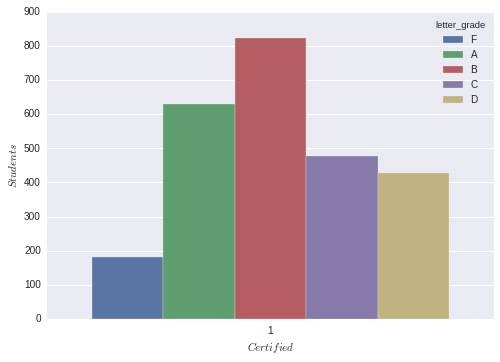

In [24]:
ax = sns.countplot(x="certified", hue="letter_grade", data=MITx_600x_active)
ax.set(ylabel='$Students$')
ax.set(xlabel='$Certified$')

Interpretations:
* Order of outcomes granted from most to least:
    * B > A > C > D > F

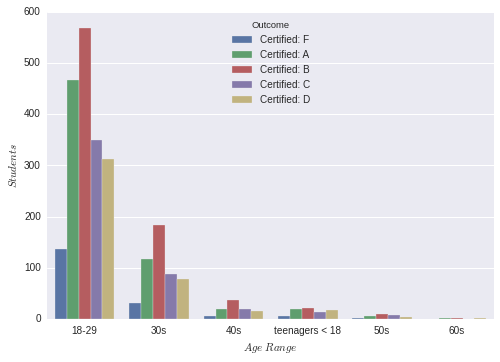

In [25]:
ax = sns.countplot(x="age_range", hue="Outcome", data=MITx_600x_active)
ax.set(ylabel='$Students$')
ax.set(xlabel='$Age$ $Range$')

Interpretations: Most students are in there 20s

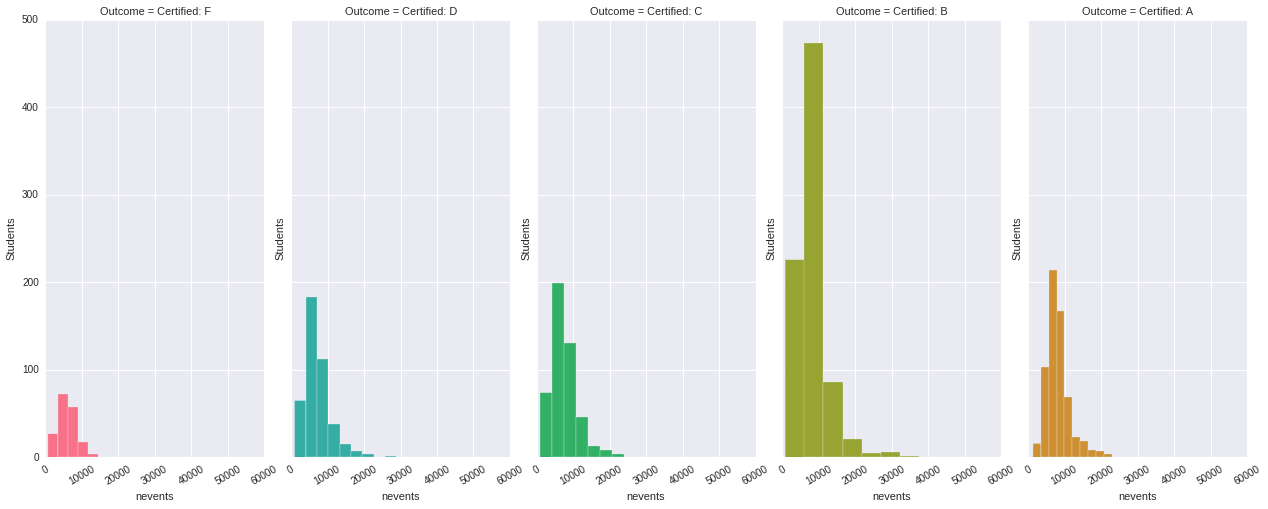

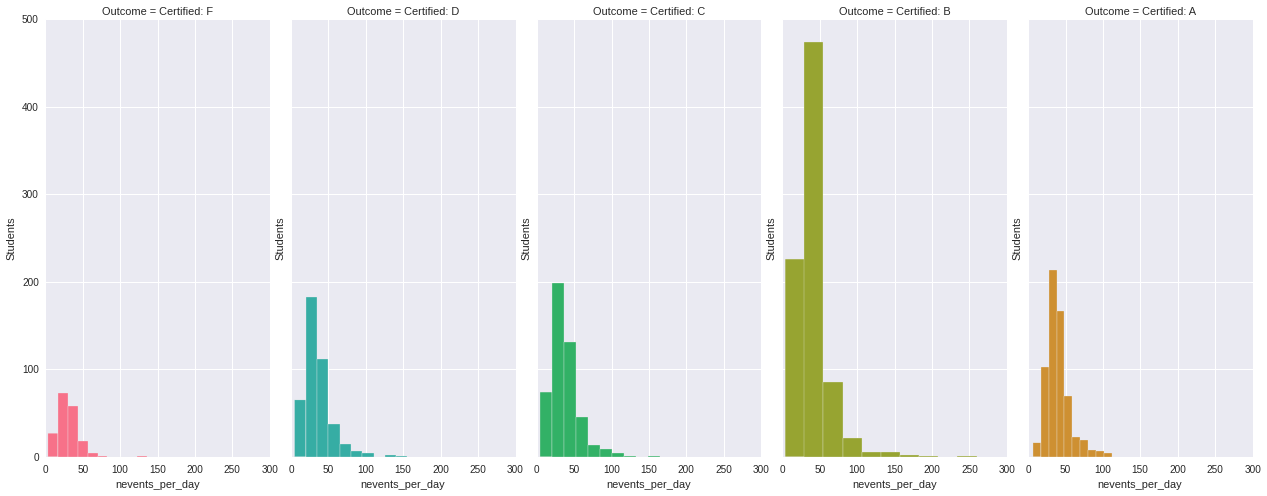

In [26]:
# browser events
nevents = sns.FacetGrid(MITx_600x_active, col='Outcome', 
                        col_order=["Certified: F", "Certified: D","Certified: C","Certified: B", "Certified: A"], 
                        hue='Outcome', size=7, aspect=.5,palette=sns.color_palette("husl", 8))
nevents = nevents.map(plt.hist, "nevents").set(ylabel='Students').set_xticklabels(rotation=30)
neventsPD = sns.FacetGrid(MITx_600x_active, col='Outcome', 
                          col_order=["Certified: F", "Certified: D", "Certified: C","Certified: B", "Certified: A"], 
                          hue='Outcome', size=7, aspect=.5,palette=sns.color_palette("husl", 8))
neventsPD = neventsPD.map(plt.hist, "nevents_per_day").set(ylabel='Students')

Interpretations:
* Students recieving Bs execute the most events

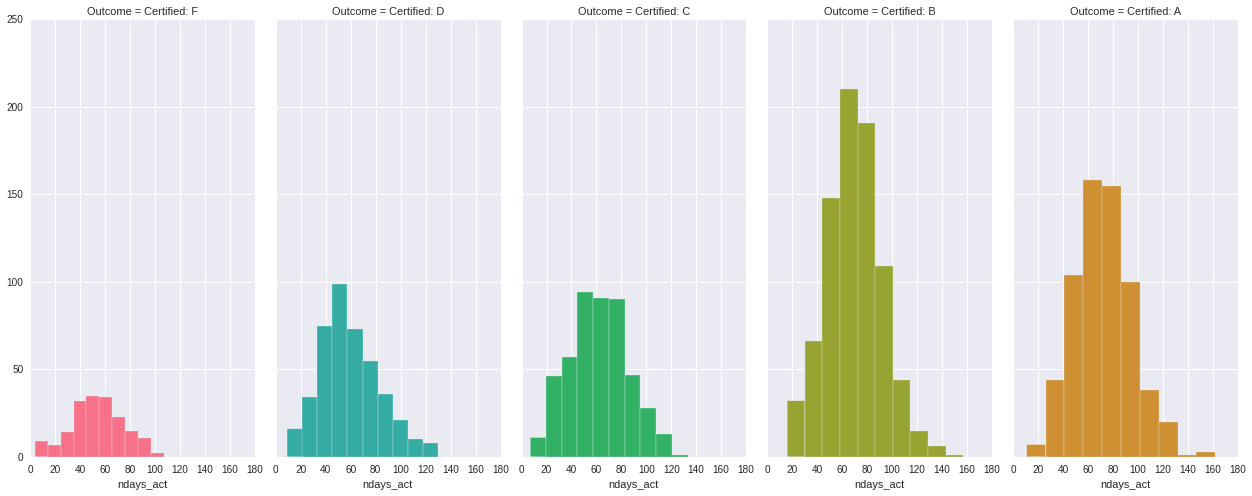

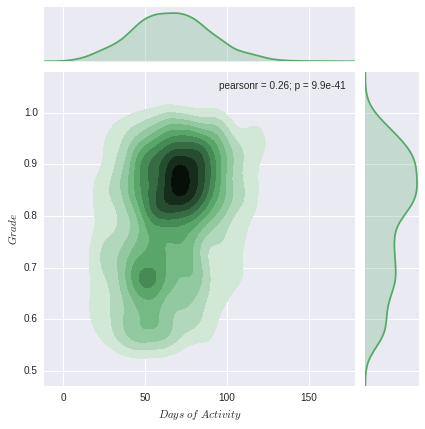

In [27]:
ndays_act = sns.FacetGrid(MITx_600x_active, col="Outcome", 
                          col_order=["Certified: F", "Certified: D", "Certified: C","Certified: B", "Certified: A"],
                          hue="Outcome", size=7, aspect=.5, 
                        palette=sns.color_palette("husl", 8))
ndays_act = ndays_act.map(plt.hist, 'ndays_act')

ax = sns.jointplot(x='ndays_act',y='grade', data=MITx_600x_active, kind='kde', color="g")
ax.ax_joint.collections[0].set_alpha(0)
ax.set_axis_labels("$Days$ $of$ $Activity$", "$Grade$")

Interpretation:
* Students recieving Bs execute are active for the most days
* Most students who receiving Bs were active between 50 to 100 days
* Most students who receiving Cs were active around 50 days   

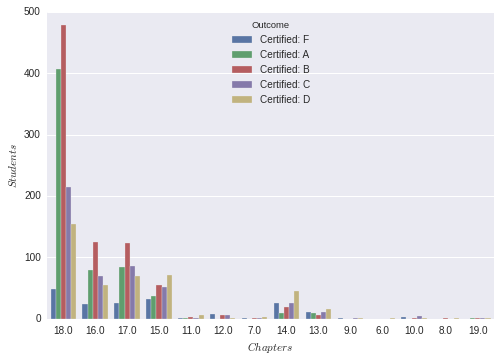

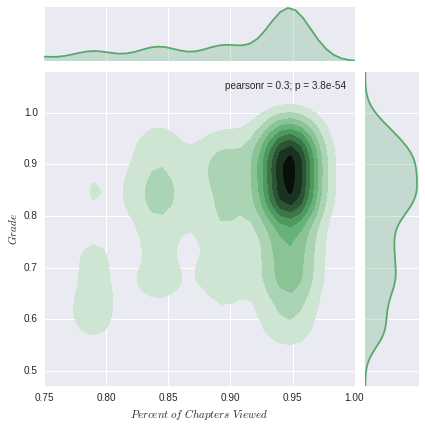

In [28]:
ax = sns.countplot(x="nchapters", hue='Outcome', data=MITx_600x_active)
ax.set(ylabel='$Students$')
ax.set(xlabel='$Chapters$')

ax = sns.jointplot(x='%max_chapters_viewed',y='grade', data=MITx_600x_active, kind='kde', color="g", xlim=(0.75,1))
ax.ax_joint.collections[0].set_alpha(0)
ax.set_axis_labels("$Percent$ $of$ $Chapters$ $Viewed$", "$Grade$")

Interpretations:
* Most students with each outcome viewed 18 chapters
* Most Students with Bs and As view around 95% of the chapters

###Creating a dataframe containing the mean of all numerical feature values of students with each outcome
* Used to represent the **kernel density** in some of the **kernel density estimation** (**kde**) plots below

In [41]:
rows = []
for i in pd.Series(MITx_600x_active['outcome'].values).unique():
    row = []
    for col in MITx_600x_active.columns[4:20]:
        row.append(MITx_600x_active[outcome_cols[4:20]][col][MITx_600x_active['outcome']==i].mean())
    rows.append(row)
mean_MITx_600x = pd.DataFrame(rows, columns=MITx_600x.columns[4:20])
mean_MITx_600x['Outcome'] = pd.Series(MITx_600x_active['Outcome'].values).unique()

In [42]:
mean_MITx_600x.head()

,grade,nevents,nchapters,nplay_video,nforum_posts,age,ndays_act,ndays_chapters,ndays_play_video,ndays_forum_posts,nchapters/nevents,nplay_video/nevents,nforum_posts/nevents,nevents_per_day,nchapters_per_day,nplay_video_per_day,Outcome
0,0.571044,6041.175824,15.565934,463.972527,0.269231,25.648352,53.280220,53.280220,53.280220,7.862637,0.003267,0.070416,0.000051,29.469150,0.075931,2.263281,Certified: F
1,0.935222,8200.269841,17.284127,691.092063,0.144444,25.984127,72.639683,72.639683,72.639683,6.130159,0.002424,0.079055,0.000020,40.001316,0.084313,3.371181,Certified: A
2,0.846204,8417.778589,17.100973,627.791971,0.178832,27.097324,70.019465,70.019465,70.019465,7.332117,0.002459,0.071574,0.000025,41.062335,0.083419,3.062400,Certified: B
3,0.744059,7549.177824,16.598326,505.190377,0.213389,25.974895,61.736402,61.736402,61.736402,9.163180,0.002777,0.062100,0.000029,36.825258,0.080967,2.464343,Certified: C
4,0.650843,7358.142857,16.175644,536.896956,0.201405,25.826698,59.370023,59.370023,59.370023,7.103044,0.002768,0.065201,0.000033,35.893380,0.078906,2.619010,Certified: D


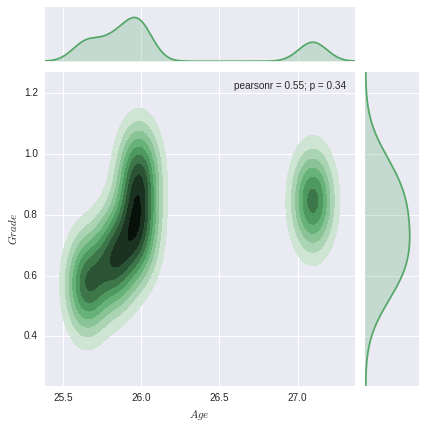

In [43]:
ax = sns.jointplot(x='age',y='grade', data=mean_MITx_600x, kind='kde', color="g")
ax.ax_joint.collections[0].set_alpha(0)
ax.set_axis_labels("$Age$", "$Grade$")

Interpretations: 
* Grade ranges tend to sharply increase from ages around 25.5 to around 27
* Most recieve grade marks around 80% are a a few weeks around 26 years of age
* Students around age 27 tend to not receive less than about 65% grade marks

### Analysing the correlation of student browser events to grade 
* Trying different **kernel densities** for the most meaningful interpretations
* Interpreting the KDE plot using **Student Outcomes** as the Kernel Density, and the mean of **browser events** associated with **grade**

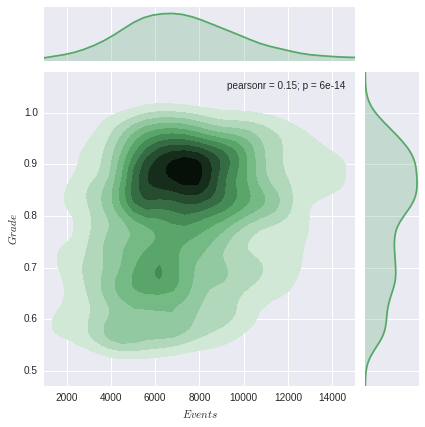

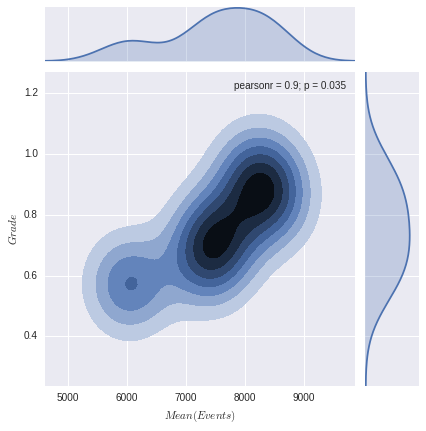

In [44]:
# Kernel Density: Students
ax = sns.jointplot(x='nevents',y='grade', data=MITx_600x_active, kind='kde', color="g", xlim=(1000,15000))
ax.ax_joint.collections[0].set_alpha(0)
ax.set_axis_labels("$Events$", "$Grade$")

# Kernel Density: Student Outcomes
ax = sns.jointplot(x='nevents',y='grade', data=mean_MITx_600x, kind='kde', color="b")
ax.ax_joint.collections[0].set_alpha(0)
ax.set_axis_labels("$Mean(Events)$", "$Grade$")

Interpretations: 
* Most students receiving Bs and As tended to execute between an average of around 8000 to 9000 browser events
* Most students receiving Cs and Ds tended to execute between an average of around 7000 to 8000 browser events
* Most students receiving around 60% grade mark tended execute an average of around 6000 browser events

Conclusion: The average of browser events is highly correlated to grade according to the Pearson correlation coefficient (pearsonr) equalling 0.9 and the p-value (p) equalling 0.035

### Analysing the correlation of video plays and plays per day to outcome and grade 
* Histogram of students video plays per outcome
* KDE plots using **Students** as the Kernel Density, and the **video plays** associated with **grade**
* KDE plots using **Student Outcomes** as the Kernel Density, and the mean of **video plays** associated with **grade**
* KDE plots using **Students** as the Kernel Density, and the mean of **video plays per day** associated with **grade**
* KDE plots using **Student Outcomes** as the Kernel Density, and the mean of **video plays per day** associated with **grade**
* Interpreting both 

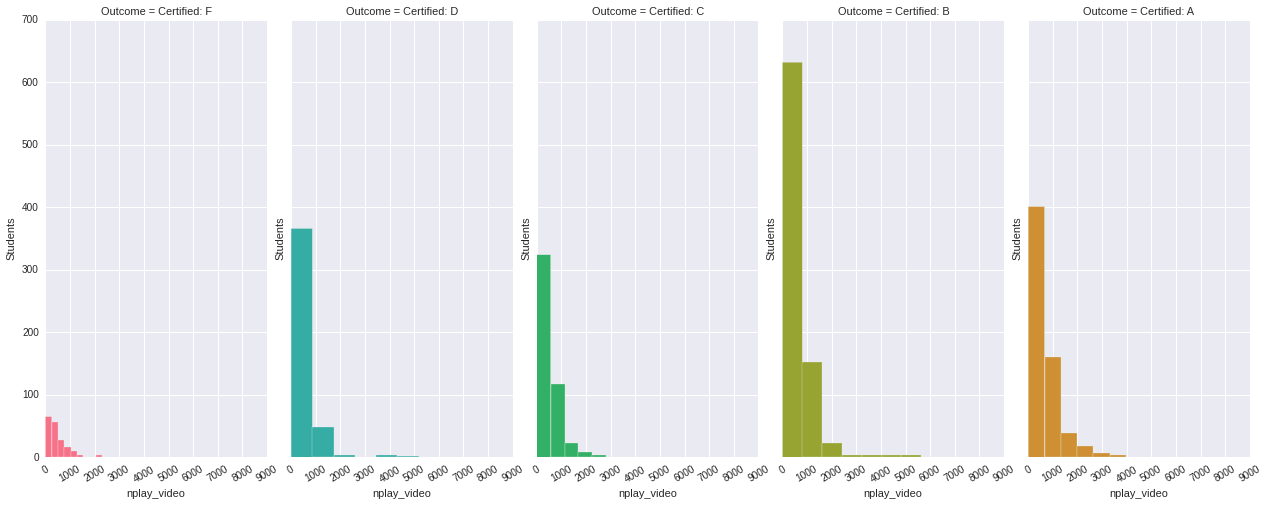

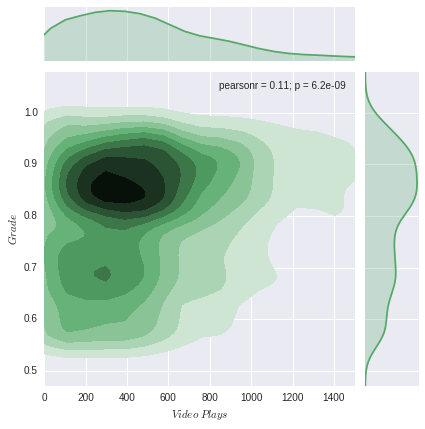

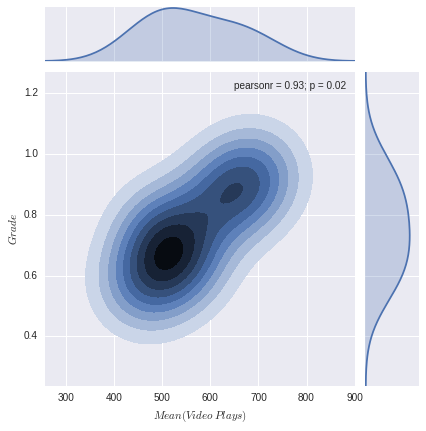

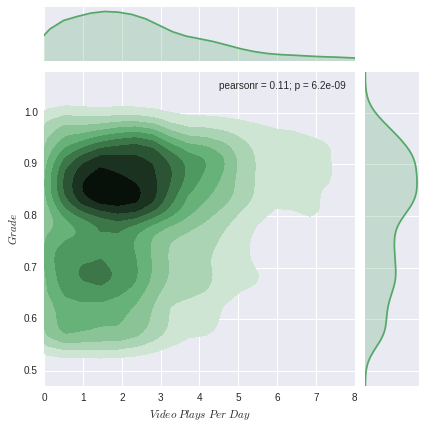

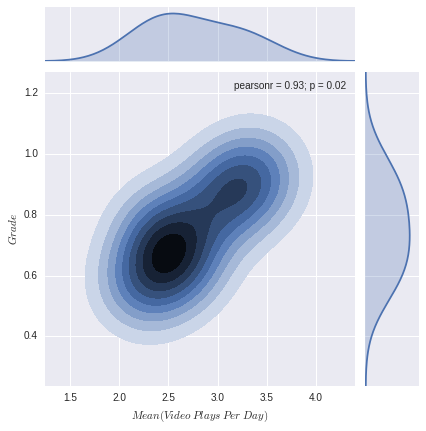

In [45]:
nplay_video = sns.FacetGrid(MITx_600x_active, col='Outcome', 
                            col_order=["Certified: F", "Certified: D","Certified: C","Certified: B", "Certified: A"], 
                            hue='Outcome', size=7, aspect=.5,palette=sns.color_palette("husl", 8))
nplay_video = nplay_video.map(plt.hist, 'nplay_video').set(ylabel='Students').set_xticklabels(rotation=30)

ax = sns.jointplot(x='nplay_video',y='grade', data=MITx_600x_active, 
                   kind='kde', color="g", xlim=(0,1500))
ax.ax_joint.collections[0].set_alpha(0)
ax.set_axis_labels("$Video$ $Plays$", "$Grade$")

ax = sns.jointplot(x='nplay_video',y='grade', data=mean_MITx_600x, 
                   kind='kde', color="b")
ax.ax_joint.collections[0].set_alpha(0)
ax.set_axis_labels("$Mean$$($$Video$ $Plays$$)$", "$Grade$")

ax = sns.jointplot(x='nplay_video_per_day',y='grade', data=MITx_600x_active, 
                   kind='kde', color="g", xlim=(0,8))
ax.ax_joint.collections[0].set_alpha(0)
ax.set_axis_labels("$Video$ $Plays$ $Per$ $Day$", "$Grade$")

ax = sns.jointplot(x='nplay_video_per_day',y='grade', data=mean_MITx_600x, 
                   kind='kde', color="b")
ax.ax_joint.collections[0].set_alpha(0)
ax.set_axis_labels("$Mean$$($$Video$ $Plays$ $Per$ $Day$$)$", "$Grade$")
# nplay_videoPD = sns.FacetGrid(MITx_600x_active, col='Outcome', 
#                               col_order=["Certified: F", "Certified: D","Certified: C","Certified: B", "Certified: A"], 
#                               hue='Outcome', size=7, aspect=.5,palette=sns.color_palette("husl", 8))
# nplay_videoPD = nplay_videoPD.map(plt.hist, 'nplay_video_per_day').set(ylabel='Students').set_xticklabels(rotation=30)

Interpretations:
* Histogram: B students play the most videos 
* KDE plot: C and D students tended to play around an average of 500 videos & 2.5 videos per day
* KDE plot: B and A students tended to play around an averages of between 600 to 700 videos & above 3 videos per day

Conclusion: The average of video plays and plays per day are highly correlated to grade according to the Pearson correlation coefficient (pearsonr) equalling 0.93 and the p-value (p) equalling 0.02

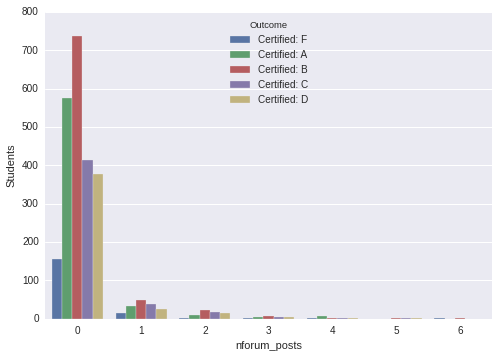

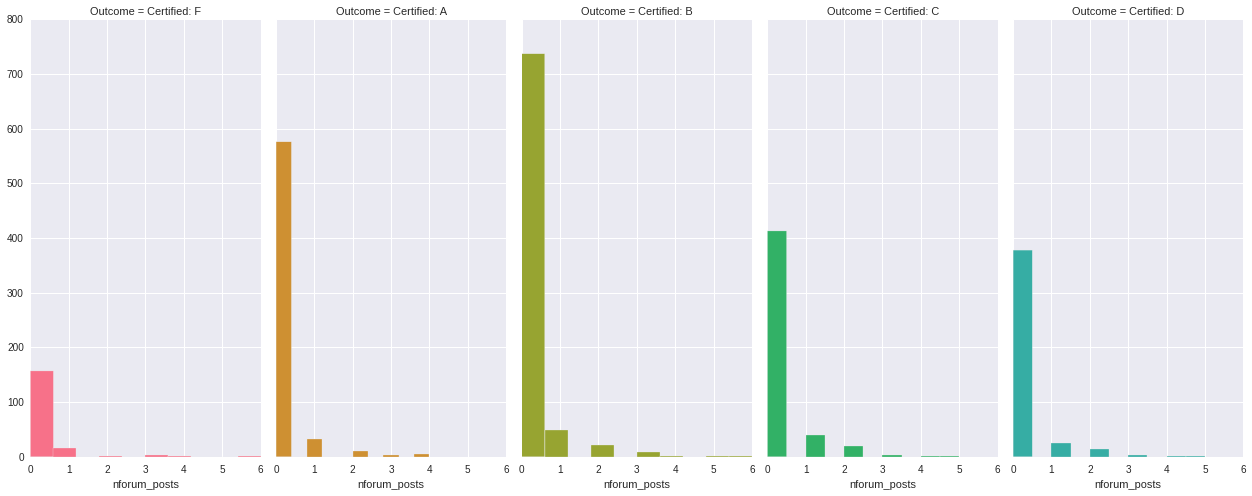

In [48]:
ax = sns.countplot(x='nforum_posts', hue="Outcome", data=MITx_600x_active, order=[0,1,2,3,4,5,6]).set(ylabel='Students')
nforum_posts = sns.FacetGrid(MITx_600x_active, col="Outcome", hue="Outcome", size=7, aspect=.5, 
                        palette=sns.color_palette("husl", 8))
nforum_posts = nforum_posts.map(plt.hist, 'nforum_posts')

Interpretation: 
* Most students don't most in the forums (89% of students didn't post in the forums)
* B students post the most in the forms

###12. (Product) Model & Evaluate best model on a course: Y = Outcome

In [49]:
outcome_cols=['Outcome',# Y: 0
              'viewed','explored',# 1,2
              'nplay_video/nevents','nforum_posts/nevents',# Act Type: 3,4
              'nevents_per_day','nchapters_per_day','nplay_video_per_day','nforum_posts_per_day',# ActPerDay: 5-8
              'ndays_play_video','ndays_chapters','ndays_forum_posts',# DaysPerAct: 9-11
              '%max_chapters_viewed',# Temp %Complete: 12
              'ndays_act','nplay_video','nchapters','nevents','nforum_posts',# Act Counts: 13-17
              'LoE_DI','age']# Demo: 18-21; 

outcome_mooc = mooc[mooc['institution']=='MITx']
outcome_mooc_inv = outcome_mooc[outcome_cols][outcome_mooc['course_code']!="6.00x"]
outcome_mooc_600x = mooc[outcome_cols][mooc['course_code']=="6.00x"]

In [53]:
X = mooc[outcome_cols[1:]][mooc['institution']=="MITx"]
y_train = outcome_mooc_inv['Outcome'] 
y_test = outcome_mooc_600x['Outcome'] 

X_train = outcome_mooc_inv[outcome_cols[1:]]
X_test = outcome_mooc_600x[outcome_cols[1:]]

Target: MITx: 6.00x
Estimator: RandomForestClassifier        

Confusion Matrix:
[[  432    53    58    19     1    67]
 [  519    60    96    19     2   126]
 [  261    23    52    11     7   124]
 [  205    30    47     5     2   138]
 [   76     7    17     2     4    76]
 [  204    28    31    30     9 48596]]

Classification_Report:
             precision    recall  f1-score   support

Certified: A       0.25      0.69      0.37       630
Certified: B       0.30      0.07      0.12       822
Certified: C       0.17      0.11      0.13       478
Certified: D       0.06      0.01      0.02       427
Certified: F       0.16      0.02      0.04       182
Not Certified: F       0.99      0.99      0.99     48898

avg / total       0.95      0.96      0.95     51437


Accuracy Score: 0.9555 - fraction of correctly classified samples
                49149  - number of correctly classified samples
 Zero One Loss: 0.0445 - return the fraction of misclassifications
                2288   - 

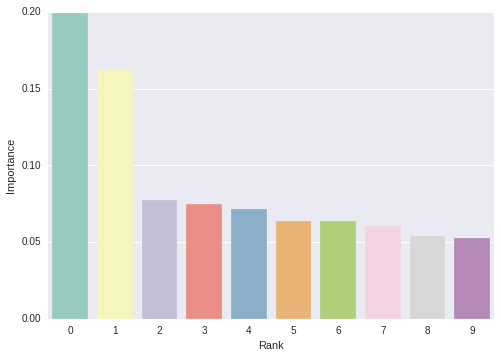

In [61]:
eval_estimator(RandomForestClassifier, X_train, y_train, X_test, y_test, "MITx: 6.00x", Y='Outcome')

### Future

##By Joshua E. Jodesty
###Objectives:
####A. Predict student outcomes in MOOCs offered by edX
* Outcomes: Certifications & Grade Range

####B. Determine browser events that affects student outcomes

####Acquisition:
[Dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/26147): 129843 student logs containing browser events

Source: edX courses administered by HarvardX & MITx from 2012 & 2013

In [15]:
# 
# def forestReport(estimator, X_test, y_test,):
#     rfclf = estimator(random_state = 777)
#     model = rfclf.fit(X_train, y_train)
    
#     y_score = model.predict_proba(X_test)
#     y_pred = model.predict(X_test)
#     y_true = np.array(np.float64(y_test))
#     folds = 10 # better metrics with more folds
#     target_names = ['Poisonoius', 'Edible']
#     #sklearn.metrics
#     #accuracy = accuracy_score(y_true, y_pred)
#     #average_precision = average_precision_score(y_test, y_score[:, 1])

#     # X_test, y_test - supervized learning

#     #X-Val Scores????
#     accuracy = np.mean(cross_val_score(rfclf, X_test, y_test, cv=folds, scoring='accuracy'))
#     precision = np.mean(cross_val_score(rfclf, X_test, y_test, cv=folds, scoring='precision'))
#     recall = np.mean(cross_val_score(rfclf, X_test, y_test, cv=folds, scoring='recall'))
#     average_precision = np.mean(cross_val_score(rfclf, X_test, y_test, cv=folds, scoring='average_precision'))
#     f1 = np.mean(cross_val_score(rfclf, X_test, y_test, cv=folds, scoring='f1'))
#     neg_log_LR = np.mean(cross_val_score(rfclf, X_test, y_test, cv=folds, scoring='log_loss'))

#     # sklearn.metrics
#     ham_loss = hamming_loss(y_true, y_pred)
#     mcc = matthews_corrcoef(y_true, y_pred)
#     jaccard = jaccard_similarity_score(y_true, y_pred)
#     brier = brier_score_loss(y_true, y_score[:,1])
#     zeroOneLoss = zero_one_loss(y_true, y_pred)
#     prfbs = precision_recall_fscore_support(y_true, y_pred)

#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()
#     fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
#     roc_auc = auc(fpr, tpr)
#     precision_PRC, recall_PRC, thresholds_PRC = precision_recall_curve(y_test, y_score[:,1])

#     print 'Random Forest Classifier'
#     print ''
#     print '%s %.4f' % ("X-Val_Score -        Accuracy:", accuracy)
#     print ''
#     print '%s %.4f' % ("X-Val_score -  Mean Precision:", precision)
#     # print '%s %.4f' % ("X-Val_score -    Mean Recall:", recall)
#     # print '%s %.4f' % ("roc_curve - Mean Threshold:", np.mean(thresholds))
#     print ''
#     print '%s %.4f' % ("PRC -           Mean Precision:", np.mean(precision_PRC))
#     # print '%s %.4f' % ("PRC -              Mean Recall:", np.mean(recall_PRC))
#     # print '%s %.4f' % ("PRC -           Mean Threshold:", np.mean(thresholds_PRC))
#     print ''
#     print '%s %.4f' % ("                            F1:", f1)
#     print '%s %.4f' % ("  Zero-one classification loss:", zeroOneLoss)
#     print '%s %.4f' % ("                           MCC:", mcc)
#     print '%s %.4f' % ('                  Hamming Loss:', ham_loss)
#     print '%s %.4f' % ('            Jaccard Similarity:', jaccard)
#     print '%s %.4f' % ('               Negative Log-LR:', neg_log_LR)
#     print '%s %.4f' % ("                         Brier:", brier)
#     print ''

#     # Avg. Precision IS Precision-Recall AUC
#     print 'AUCs:'
#     print '%s %.4f' % ('             ROC -', roc_auc)
#     print '%s %.4f' % ('Precision-Recall -', average_precision)
#     print '*Note: average_precision = Precision-Recall AUC'
#     print ''
#     #RESEARCH: Weight for E/P for imputs, y_score[:,1]

#     print '%s %.0f' % ('Poisonoius in Actual:', len(y_test.loc[y_test == 0]))
#     print '%s %.0f' % ('Edible in Actual:', len(y_test.loc[y_test == 1]))
#     print '%s %.0f' % ('All in Actual:', len(y_test))
#     print ''

#     print "Classification Report:"
#     print classification_report(y_test, y_pred, target_names=target_names)

#     print '%s %.0f' % ('Poisonoius in Actual:', len(y_test.loc[y_test == 0]))
#     print '%s %.0f' % ('Edible in Actual:', len(y_test.loc[y_test == 1]))
#     print '%s %.0f' % ('All in Actual:', len(y_test))
#     print ''

#     def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
#         plt.imshow(cm, interpolation='nearest', cmap=cmap)
#         plt.title(title)
#         plt.colorbar()
#         plt.tight_layout()
#         plt.ylabel('True label')
#         plt.xlabel('Predicted label')
#     cm = confusion_matrix(y_true, y_pred)
#     print "Confusion Matrix: "
#     print cm

#     # Plot CM
#     plt.figure()
#     plot_confusion_matrix(cm)

#     # Plot of a ROC curve for a specific class
#     plt.figure()
#     plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()
#     print ''
#     # Plot Precision-Recall curve
#     plt.clf()
#     plt.plot(recall_PRC, precision_PRC, label='Precision-Recall curve')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
#     plt.legend(loc="lower left")
#     plt.show()